In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

# Read Captions File

In [2]:
# Reading the Description file

with open('text/Flickr8k.token.txt') as filepath:
    captions = filepath.read()
    filepath.close()

In [3]:
captions = captions.split("\n")[:-1]

In [4]:
len(captions)

40459

In [5]:
# creating a "descriptions" dictionary  where key is 'img_name' and value is list of captions corresponding to that image_file.

descriptions = {}

for ele in captions:
    i_to_c = ele.split("\t")
    img_name = i_to_c[0].split(".")[0]
    cap = i_to_c[1]
    
    if descriptions.get(img_name) == None:
        descriptions[img_name] = []

    descriptions[img_name].append(cap)

In [6]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

# Data Cleaning

In [7]:
""" 1. lower each word
    2. remove puntuations
    3. remove words less than length 1 """ 

def clean_text(sample):
    sample = sample.lower()
    
    sample = re.sub("[^a-z]+"," ",sample)
    
    sample = sample.split()
    
    sample = [s for s in sample if len(s)>1]
    
    sample = " ".join(sample)
    
    return sample

In [8]:
clean_text("My noghsujf si am m cricket101 &8 mphi*&86%%&??,BY6fajdn 213 q rqu243 boy  32 ewr wO>>J DHD 34  asfb HHGY Gvg HgB   231 123")

'my noghsujf si am cricket mphi by fajdn rqu boy ewr wo dhd asfb hhgy gvg hgb'

In [9]:
#  modify all the captions i.e - cleaned captions

for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])

In [10]:
#  clean descriptions

descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [11]:
# writing clean description to .txt file

f = open("descriptions.txt","w")
f.write( str(descriptions) )
f.close()

In [12]:
#  reading description file

f = open("descriptions.txt", 'r')
descriptions = f.read()
f.close()

json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

In [13]:
# finding the unique vocabulary 

vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]

print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8424


In [14]:
#  ALl words in description dictionary
all_vocab =  []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size: %d' % len(all_vocab))
print(all_vocab[:15])

Vocabulary Size: 373830
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [15]:
#  count the frequency of each word, sort them and discard the words having frequency lesser than threshold value

import collections


counter= collections.Counter(all_vocab)

dic_ = dict(counter)

threshelod_value = 10

sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]

In [16]:
len(all_vocab)

1845

# Loading Training Testing Data

In [18]:
# TrainImagesFile
f = open('text/Flickr_8k.trainImages.txt')
train = f.read()
f.close()

In [19]:
train  = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [20]:
# TestImagesFile
f = open('text/Flickr_8k.testImages.txt')
test = f.read()
f.close()

In [21]:
test  = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [22]:
# create train_descriptions dictionary, which will be similar to earlier one, but having only train samples
# add startseq + endseq 

train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

In [23]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

# Data Preprocessing - Images

In [ ]:
"""
In this section, we will load our images and do some processing so that we can feed it in our network.
"""

In [24]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))

In [25]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [26]:
# Create a new model, by removing the last layer (output layer of 1000 classes) from the resnet50
model_new = Model(model.input, model.layers[-2].output)

In [27]:
images = "./Flickr8k_Dataset/"

In [28]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [29]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [30]:
start = time()

encoding_train = {}

for ix, img in enumerate(train):
    
    img = "./flicker8k-dataset/Flickr8k_Dataset/{}.jpg".format(train[ix])
    encoding_train[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

FileNotFoundError: [Errno 2] No such file or directory: './flicker8k-dataset/Flickr8k_Dataset/2513260012_03d33305cf.jpg'

In [31]:
# Save the bottleneck train features to disk

with open("./storage/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [136]:

encoding_test = {}

for ix,img_id in enumerate(test):
    imgpath = "Flicker8k_Dataset/"+img_id+".jpg"
    encoding_test[img_id]=encode_image(imgpath)

In [127]:
'''
start = time()

encoding_test = {}

for ix, img in enumerate(test):

    img = "Flicker8k_Dataset/{}.jpg".format(test[ix])
    encoding_test[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)
'''

Encoding image- 0


Exception ignored in: <function ScopedTFGraph.__del__ at 0x000001CC7C5CEDC0>
Traceback (most recent call last):
  File "c:\users\dell\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 58, in __del__
    self.deleter(self.graph)
KeyboardInterrupt: 


Encoding image- 100
Encoding image- 200
Encoding image- 300


KeyboardInterrupt: 

In [138]:
# Save the bottleneck train features to disk

with open("./storage/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [58]:
# Load the train images features from disk

with open("./storage/encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [139]:
# Load the test images features from disk

with open("./storage/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [137]:
encoding_test

{'3385593926_d3e9c21170': array([0.33316913, 0.38347778, 0.07253448, ..., 0.90832144, 0.35600525,
        1.0914086 ], dtype=float32),
 '2677656448_6b7e7702af': array([0.29456037, 0.09500366, 0.7013545 , ..., 0.0199676 , 0.29111892,
        0.1095927 ], dtype=float32),
 '311146855_0b65fdb169': array([0.01133578, 0.08780406, 0.14325371, ..., 0.03005866, 1.1857145 ,
        0.06954575], dtype=float32),
 '1258913059_07c613f7ff': array([0.04770475, 1.4354502 , 0.10770203, ..., 0.13344468, 0.11505595,
        2.0496235 ], dtype=float32),
 '241347760_d44c8d3a01': array([0.0655283 , 6.6828322 , 0.31763455, ..., 0.06200393, 0.03742843,
        0.04522505], dtype=float32),
 '2654514044_a70a6e2c21': array([1.9562044 , 0.04316794, 0.11143821, ..., 0.0200832 , 0.6832548 ,
        0.43294114], dtype=float32),
 '2339106348_2df90aa6a9': array([0.08876362, 1.1927909 , 0.0767651 , ..., 0.01899936, 0.13417532,
        0.13799469], dtype=float32),
 '256085101_2c2617c5d0': array([0.6191811 , 0.59047735, 0

# Data Preprocessing - Captions

In [148]:
"""
word_to_idx is mapping between each unique word in all_vocab to int value 
and idx_to_word is vice-versa
"""


ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1    

In [149]:
#  need to add these 2 words as well

word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [150]:
#  vocab_size is total vocabulary len +1 because we will append 0's as well. 

vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [151]:
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


In [152]:
with open("./storage/word_to_idx.pkl", "wb") as w2i:
    pickle.dump(word_to_idx, w2i)

In [153]:
with open("./storage/idx_to_word.pkl", "wb") as i2w:
    pickle.dump(idx_to_word, i2w)

# Data Preparation using Generator Function

In [23]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key+".jpg"]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

# Word Embedding

In [47]:
f = open("glove.6B.50d.txt", encoding='utf8')

In [48]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()

## Converting words into vectors  Directly - (Embedding Layer Output)

In [49]:
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()

In [50]:
embedding_output.shape

(1848, 50)

# Model Architecture

In [29]:
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [30]:
# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [31]:
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_3 

In [35]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [36]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

# Train Our Model

In [37]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [38]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
2000/2000 [==============================] - 189s 95ms/step - loss: 4.2791
Epoch 1/1
2000/2000 [==============================] - 180s 90ms/step - loss: 3.5671
Epoch 1/1
2000/2000 [==============================] - 191s 95ms/step - loss: 3.3153
Epoch 1/1
2000/2000 [==============================] - 191s 96ms/step - loss: 3.1609
Epoch 1/1
2000/2000 [==============================] - 186s 93ms/step - loss: 3.0468
Epoch 1/1
2000/2000 [==============================] - 184s 92ms/step - loss: 2.9644
Epoch 1/1
2000/2000 [==============================] - 186s 93ms/step - loss: 2.8949
Epoch 1/1
2000/2000 [==============================] - 185s 93ms/step - loss: 2.8408
Epoch 1/1
2000/2000 [==============================] - 195s 97ms/step - loss: 2.7902
Epoch 1/1
2000/2000 [==============================] - 182s 91ms/step - loss: 2.7536


In [94]:
model = load_model("./model_weights/model_9.h5")

# Predictions

In [145]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

In [146]:
images = 'Flicker8k_Dataset/'

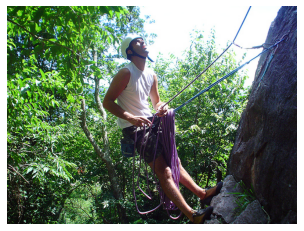

man in red shirt is rock climbing


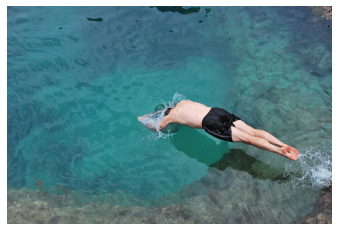

young girl in blue bathing suit is jumping into pool


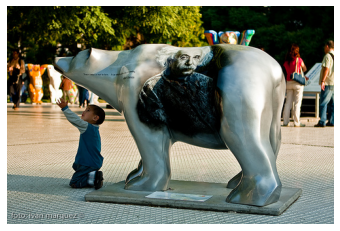

two dogs are playing with each other


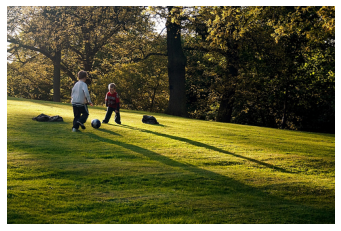

young girl in green shirt is running through field of grass


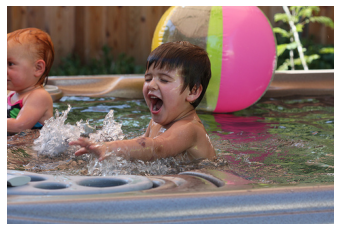

little boy in blue shirt is playing with multi inflatable toy


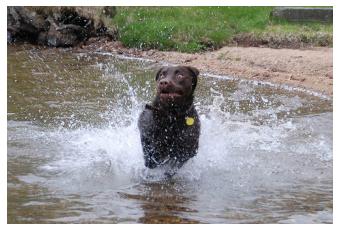

black dog is running through the water


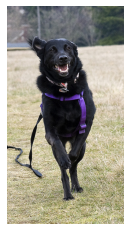

black dog is running on the grass


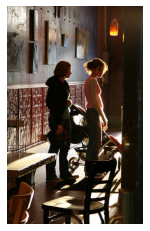

man and woman sit on bench


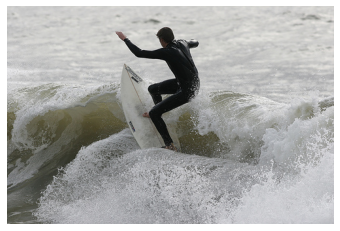

surfer wearing black wetsuit is riding on the waves


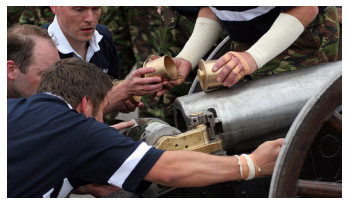

man and woman sit on bench


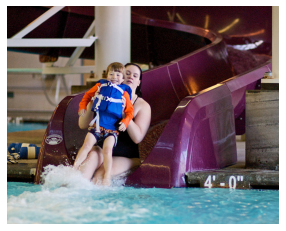

young boy in red shirt is jumping into pool


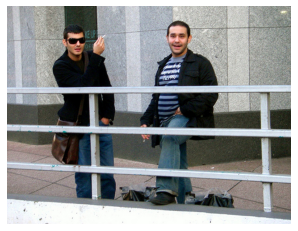

man in black shirt and black hat is standing on bench in front of some


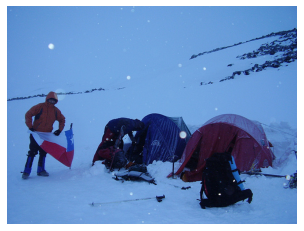

man in red and white coat is standing in the snow


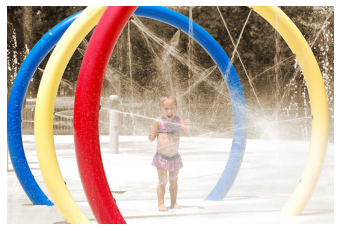

little girl in red shirt is jumping up of slide


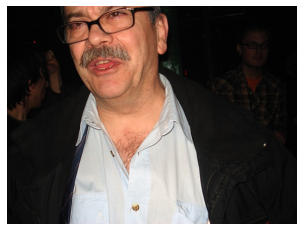

man with glasses and leather jacket is standing in front of brick wall


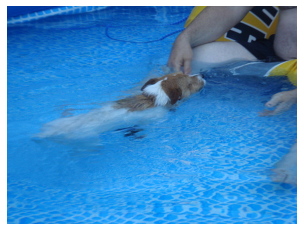

little boy in blue bathing suit is jumping into pool


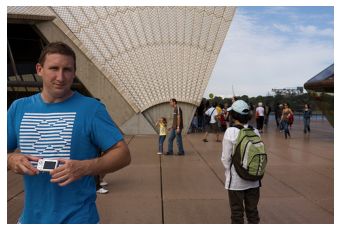

man with camera is standing on tripod and another man stands on the phone


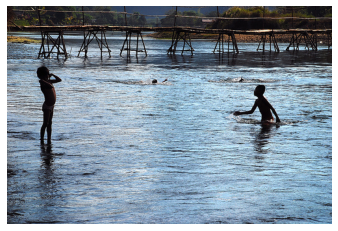

man is in the water


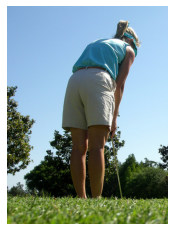

little girl in white shirt is jumping on the sand


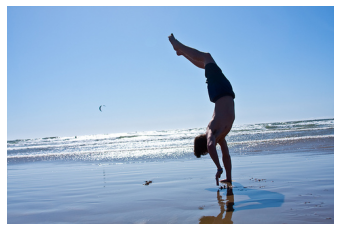

girl in white shirt is walking in the beach


In [147]:
for i in range(20):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(images+img_name+'.jpg')
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)

In [98]:
caption


'black dog jumps up to catch ball'